In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, classification_report, roc_curve
from sklearn.model_selection import RandomizedSearchCV

import numpy as np
from sklearn.metrics import roc_auc_score
import warnings
from sklearn.dummy import DummyClassifier
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./Data Exploration/wdbc.csv')
df = df.drop(["Area", "AreaSE", "AreaWorst","Perimeter", "PerimeterSE", "PerimeterWorst"], axis = 1)
encoder = LabelEncoder().fit(df["B/M"])
df['B/M'] = encoder.transform(df["B/M"])
not_data = ["ID", "B/M"]
label = df["B/M"]
feature = df.drop(not_data, axis = 1)
data = pd.concat([label, feature], axis=1)

In [3]:
x_train, x_test, y_train, y_test = train_test_split(feature, label, test_size=0.2, stratify=label, random_state=3) #0.4 -> 0.2

#x_test, x_val, y_test, y_val = train_test_split(x_train, y_train, test_size=0.5, stratify=y_train, random_state = 3)

## Initial Model

In [4]:
rfc_og = RandomForestClassifier(n_estimators=100, oob_score=True, bootstrap=True, random_state=12)
rfc_og.fit(x_train, y_train)

RandomForestClassifier(oob_score=True, random_state=12)

In [5]:
def bench_marks(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Recall: {recall_score(y_test, y_pred)}')
    print(f'Precision: {precision_score(y_test, y_pred)}')

y_pred = rfc_og.predict(x_test)
bench_marks(y_test, y_pred)
print(rfc_og.oob_score_)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

[[71  1]
 [ 2 40]]
Accuracy: 0.9736842105263158
Recall: 0.9523809523809523
Precision: 0.975609756097561
0.9626373626373627


## Feature Selection

In [6]:
feature_scores = pd.Series(rfc_og.feature_importances_, index=x_train.columns).sort_values(ascending=False)
print(feature_scores)
feature_scores = feature_scores.index.tolist() # For later use

ConcavePointsWorst       0.178489
RadiusWorst              0.175690
ConcavePoints            0.169910
Concavity                0.075145
Radius                   0.068152
ConcavityWorst           0.056167
RadiusSE                 0.041170
CompactnessWorst         0.037142
Texture                  0.027847
TextureWorst             0.027721
Compactness              0.025607
ConcavePointsSE          0.014409
ConcavitySE              0.013569
SymmetryWorst            0.013257
FractalDimension         0.010716
SmoothnessWorst          0.010224
SymmetrySE               0.008956
Smoothness               0.008527
FractalDimensionSE       0.007912
TextureSE                0.007300
CompactnessSE            0.006532
FractalDimensionWorst    0.006201
SmoothnessSE             0.005739
Symmetry                 0.003617
dtype: float64


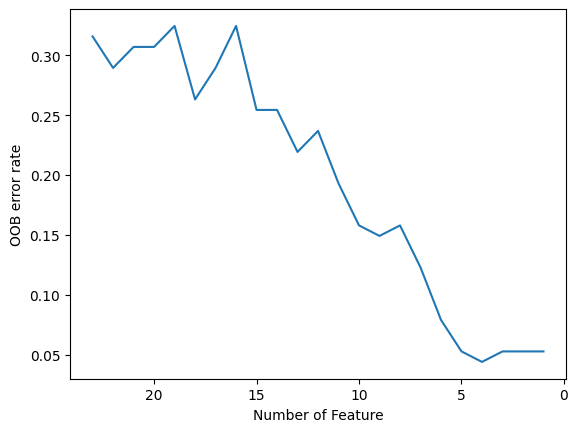

In [7]:
idx = []
error_rate = []
tempx = x_test
f_rm = 0
rfc_og = RandomForestClassifier(n_estimators=100, oob_score=True, bootstrap=True, random_state=3)

for i in feature_scores:
    rfc_og.fit(tempx, y_test)
    oob_error = 1 - rfc_og.oob_score_
    error_rate.append(oob_error)

    f_rm += 1
    idx.append(f_rm)

    tempx = tempx.drop(i, axis = 1)
    if len(tempx.columns) <= 1:
        break
plt.plot(idx, error_rate)
plt.xlabel("Number of Feature")
plt.ylabel("OOB error rate")
plt.gca().invert_xaxis()
plt.show()

In [8]:
rfecv = RFECV(estimator=rfc_og, step=1, cv=5,scoring='accuracy')
rfecv = rfecv.fit(x_train, y_train)
print("Removed n features:", rfecv.n_features_)
print(x_train.columns[rfecv.support_])
feature_select = feature[x_train.columns[rfecv.support_]]

Removed n features: 17
Index(['Radius', 'Texture', 'Compactness', 'Concavity', 'ConcavePoints',
       'FractalDimension', 'RadiusSE', 'TextureSE', 'ConcavitySE',
       'ConcavePointsSE', 'RadiusWorst', 'TextureWorst', 'SmoothnessWorst',
       'CompactnessWorst', 'ConcavityWorst', 'ConcavePointsWorst',
       'SymmetryWorst'],
      dtype='object')


In [9]:
# New train/ validation/ test sets from new feature selection
x_train, x_test, y_train, y_test = train_test_split(feature_select, label, test_size=0.2, stratify=label, random_state=3)
#x_train, x_val, y_train, y_val = train_test_split(x_train_whole, y_train_whole, test_size=0.5, stratify=y_train_whole, random_state=3)
#No need if we use OOB for scoring

In [10]:
rfc_og.fit(x_train, y_train)

y_pred = rfc_og.predict(x_test)
bench_marks(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        72
           1       0.95      0.95      0.95        42

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114

[[70  2]
 [ 2 40]]
Accuracy: 0.9649122807017544
Recall: 0.9523809523809523
Precision: 0.9523809523809523


## Hyperparameter Tuning

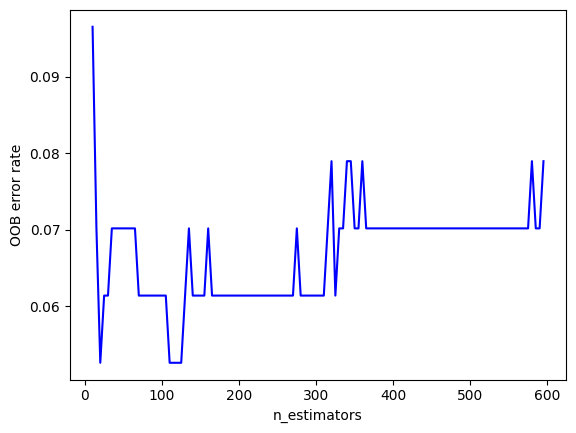

In [11]:
#Helps us decide how many n_estimators to use
idx = []
error_rate = []
min_estimators = 10
max_estimators = 600

for i in range(min_estimators, max_estimators - 1, 5):
    rfc_og.set_params(n_estimators=i)
    rfc_og.fit(x_test, y_test)
    oob_error = 1 - rfc_og.oob_score_
    idx.append(i)
    error_rate.append(oob_error)

plt.plot(idx, error_rate, "-b")
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.show()

In [12]:
n_estimators = [x for x in range(100, 500, 10)] # Use prev graph or use this
max_depth = [5, 6, 7, 8, 9, 10, 11, 12,13, 14, 15, 16, 17]
max_features = ["sqrt", "log2"] #Using OOB, so can't be 'None'
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10] #If too high, not enought OOB
min_samples_leaf = [1, 2, 3, 4, 5, 7]
criterion=['gini', 'entropy']

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion}

# Not doing bootstrap, as must be set to true for when we need OOB

In [13]:
rf_random = RandomizedSearchCV(estimator = rfc_og, param_distributions = random_grid, n_iter = 200, cv = 5, n_jobs = -1, random_state=3, scoring=lambda c,x,y: c.oob_score_)
rf_random.fit(x_train, y_train)
rfc_best = rf_random.best_estimator_

In [14]:
y_pred = rfc_best.predict(x_test)
print(rf_random.best_estimator_)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'OOB Score:{rfc_best.oob_score_}')

RandomForestClassifier(criterion='entropy', max_depth=7, min_samples_split=7,
                       n_estimators=220, oob_score=True, random_state=3)
Accuracy: 0.9736842105263158
Recall: 0.9523809523809523
Precision: 0.975609756097561
OOB Score:0.9626373626373627


## Evaluating our Model

Text(0.5, 0, 'Num. samples')

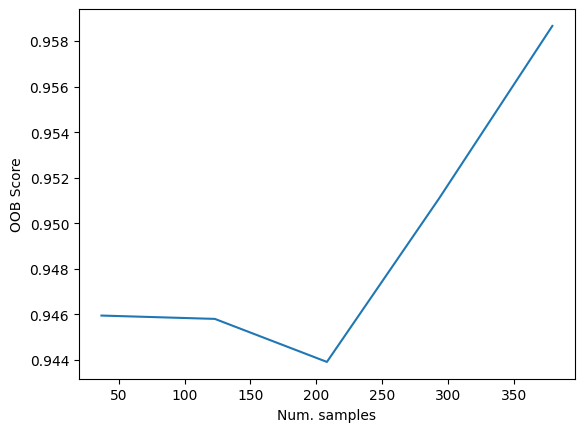

In [15]:
from sklearn.metrics import make_scorer
scorer_oob = make_scorer(rfc_best.oob_score_)
# why not work??
train_sizes_abs_accuracy, train_accuracy, test_accuracy = learning_curve(rfc_best, feature_select, label, cv=3,random_state=3, scoring=lambda c,x,y: c.oob_score_)

train_avg_accuracy, test_avg_accuracy, train_avg_error, test_avg_error = [], [], [], []

# We don't include the training set results, as our model we use bootstrapping which is cause overfitting of the training set.

for i in range(len(train_sizes_abs_accuracy)):
    train_avg_accuracy.append(np.average(train_accuracy[i]))
    test_avg_accuracy.append(np.average(test_accuracy[i]))

# Accuracy learning curve
plt.plot(train_sizes_abs_accuracy, test_avg_accuracy)
plt.ylabel('OOB Score')
plt.xlabel('Num. samples')

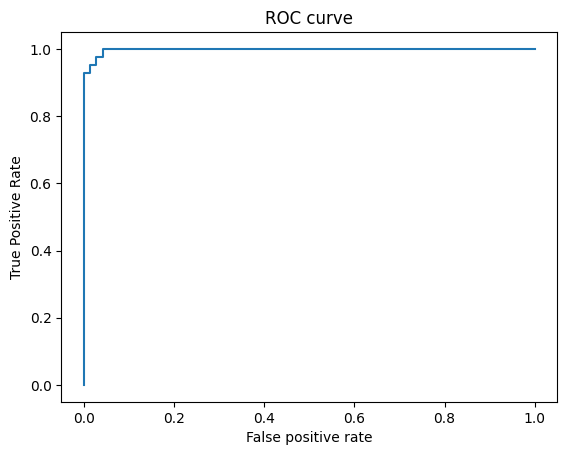

In [16]:
y_real_pred = rfc_best.predict(x_test)
auc = roc_auc_score(y_test, y_real_pred)

y_pred_prob = rfc_best.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])

plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True Positive Rate')
plt.show()

In [17]:
dm = DummyClassifier()
dm.fit(x_train, y_train)
dummy_score = dm.score(x_test, y_test)
y_pred = rfc_best.predict(x_test)  # Model classifications
accuracy = accuracy_score(y_test, y_pred)
print(f'{"Our model beats the dummy model" if accuracy > dummy_score else "Our model does not beat the dummy model."}')

Our model beats the dummy model


In [18]:
print(classification_report(y_test, y_real_pred))
c = confusion_matrix(y_test, y_real_pred)
print(f"Total Samples{len(y_test)}")
print(f'True negatives: {c[0][0]}')
print(f'False negatives: {c[1][0]}')
print(f'True positives: {c[1][1]}')
print(f'False positives: {c[0][1]}')
print(f"False Positive Rate:{(c[0][0]) / ((c[0][0]) + (c[0][1]))}")
print(f"True Positive Rate:{(c[1][1]) /((c[1][1]) + (c[1][0]) )}")


              precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Total Samples114
True negatives: 71
False negatives: 2
True positives: 40
False positives: 1
False Positive Rate:0.9861111111111112
True Positive Rate:0.9523809523809523
